In [1]:
%load_ext sql
%sql sqlite:///../data/databases/mlb.db

import pandas as pd
import numpy as np
import pybaseball
from pybaseball import statcast
import sqlite3

import torch
import torch.nn as nn
import torch.optim as optim

In [18]:
%sql select pitch_type, 

33

# Statcast View
## general game info:
- game_date
- game_pk
- game_type
- home_team
- away_team
- 
  
## game_state:
- at_bat_number
- pitch_number
- inning_topbot
- inning
- home_score
- away_score
  
- pitcher
- p_throws
  
- fielder_2 as catcher
- fielder_3 as 1B
- fielder_4 as 2B
- fielder_5 as 3B
- fielder_6 as SS
- fielder_7 as LF
- fielder_8 as CF
- fielder_9 as RF

- batter
- stand as batter_stands

- on_3b
- on_2b
- on_1b

these are pre pitch
- strikes
- balls
- outs_when_up

## individual pitch info:

these are values which will be randomly generated from pitcher model
- pitch_type

- release_speed
- release_spin
- release_extension
- release_pos_x
- release_pos_y
- release_pos_z

- pfx_x (spin induced movements of pitch)
- pfx_z

- plate_x
- plate_z

- vx0 (pitch velocity)
- vy0
- vz0
- ax (acceleration)
- ay
- az

- zone
- sz_top (top of current batter strike zone)
- sz_bot
 
- bb_type
- type (ball = B, strike = S, in play = X)



- events
- description

Where is the ball going to go?
- hc_x (hit coord)
- hc_y
- 

In [4]:
%sql select distinct home_team, away_team, game_pk from Statcast where DATE(game_date) = '2024-04-30'

 * sqlite:///../data/databases/mlb.db
Done.


home_team,away_team,game_pk
AZ,LAD,747210
BAL,NYY,747047
BOS,SF,746968
CWS,MIN,746806
DET,STL,746481
DET,STL,746477
HOU,CLE,746398
LAA,PHI,746239
MIA,COL,746073
MIL,TB,745997


In [6]:
%sql select * from Statcast where batter=686681 limit 5;

 * sqlite:///../data/databases/mlb.db
Done.


pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
CU,2024-04-29 00:00:00.000000,83.1,-1.74,5.58,"Pearson, Nate",686681,663878,strikeout,swinging_strike,None,None,None,None,14,Michael Massey strikes out swinging.,R,L,R,TOR,KC,S,2,None,1,2,2024,0.84,-0.96,0.98,1.03,677951,None,680118,2,9,Top,None,None,None,None,643376,None,None,4.621764232102647,-120.94247176192262,-2.0519150032448925,7.279985916197979,25.11388630479856,-41.32076441363254,3.49,1.67,None,None,None,83.8,2561,6.9,744945,665489,624415,676391,643396,676914,662139,543807,53.6,None,None,0.0,1,0,0,None,81,7,Curveball,6,5,5,6,5,6,5,6,Standard,Standard,43,0.159,-0.292
FF,2024-04-29 00:00:00.000000,98.2,-2.01,5.32,"Pearson, Nate",686681,663878,None,foul,None,None,None,None,1,Michael Massey strikes out swinging.,R,L,R,TOR,KC,S,None,None,1,2,2024,-0.86,1.38,-0.82,2.97,677951,None,680118,2,9,Top,None,None,None,None,643376,None,None,5.2917814917705295,-142.81838467792198,-4.106373289517196,-13.05334125771572,35.13527949030395,-12.536655321700284,3.49,1.67,249,76.2,35,99.4,2261,7.1,744945,665489,624415,676391,643396,676914,662139,543807,53.38,None,None,None,None,None,None,None,81,6,4-Seam Fastball,6,5,5,6,5,6,5,6,Standard,Standard,220,0.0,0.0
CU,2024-04-29 00:00:00.000000,81.9,-1.82,5.65,"Pearson, Nate",686681,663878,None,foul,None,None,None,None,14,Michael Massey strikes out swinging.,R,L,R,TOR,KC,S,None,None,1,2,2024,0.92,-1.1,0.92,2.19,677951,None,680118,2,9,Top,None,None,None,None,643376,None,None,4.461497989317409,-119.17494836434416,1.0101776362656831,7.644068295874425,26.335733097648397,-43.00577001386978,3.49,1.67,22,92.6,-5,82.1,2642,6.8,744945,665489,624415,676391,643396,676914,662139,543807,53.71,None,None,None,None,None,None,None,81,5,Curveball,6,5,5,6,5,6,5,6,Standard,Standard,48,0.0,0.0
FF,2024-04-29 00:00:00.000000,99.8,-2.0,5.39,"Pearson, Nate",686681,663878,None,foul,None,None,None,None,1,Michael Massey strikes out swinging.,R,L,R,TOR,KC,S,None,None,1,2,2024,-0.72,1.27,-0.62,3.58,677951,None,680118,2,9,Top,None,None,None,None,643376,None,None,5.546264214811409,-145.15702375454595,-2.566747312333145,-11.47062042669423,36.80849694481988,-13.873443430399288,3.49,1.67,226,81.5,23,100.5,2069,6.9,744945,665489,624415,676391,643396,676914,662139,543807,53.63,None,None,None,None,None,None,None,81,4,4-Seam Fastball,6,5,5,6,5,6,5,6,Standard,Standard,219,0.0,0.0
FF,2024-04-29 00:00:00.000000,99.0,-2.06,5.29,"Pearson, Nate",686681,663878,None,foul,None,None,None,None,7,Michael Massey strikes out swinging.,R,L,R,TOR,KC,S,None,None,1,1,2024,-0.92,1.51,-0.69,2.08,677951,None,680118,2,9,Top,None,None,None,None,643376,None,None,5.960764209522332,-143.88216223981084,-6.872703390822142,-14.189984206955636,36.21386806778879,-9.789100061407076,3.49,1.67,227,70.2,38,99.8,2320,7.0,744945,665489,624415,676391,643396,676914,662139,543807,53.51,None,None,None,None,None,None,None,81,3,4-Seam Fastball,6,5,5,6,5,6,5,6,Standard,Standard,215,0.0,-0.092


In [30]:
#%sql select distinct events from Statcast where batter=686681 and hit_location is not null
%sql select distinct launch_speed_angle from Statcast where batter=686681

 * sqlite:///../data/databases/mlb.db
Done.


launch_speed_angle
None
3
2
1
4
6
5


In [22]:
massey = %sql select pitch_type, events, description, hit_distance_sc, hit_location, launch_speed, launch_angle from Statcast where batter=686681
massey = massey.DataFrame()
massey[~massey['hit_location'].isna()]

 * sqlite:///../data/databases/mlb.db
Done.


,pitch_type,events,description,hit_distance_sc,hit_location,launch_speed,launch_angle
0,CU,strikeout,swinging_strike,NaN,2.0,NaN,NaN
7,SI,field_out,hit_into_play,329.0,7.0,90.6,30.0
8,SI,field_out,hit_into_play,5.0,3.0,85.3,-22.0
10,SI,grounded_into_double_play,hit_into_play,28.0,6.0,81.2,-2.0
18,SL,single,hit_into_play,14.0,6.0,55.6,-8.0
...,...,...,...,...,...,...,...
2763,None,force_out,hit_into_play,NaN,3.0,NaN,NaN
2764,None,double_play,hit_into_play,NaN,3.0,NaN,NaN
2765,FF,double,hit_into_play,361.0,7.0,93.6,28.0
2770,CH,single,hit_into_play,194.0,7.0,69.6,23.0


In [23]:
event_counts_by_hit_location = massey.groupby(['hit_location','events']).size()

print(event_counts_by_hit_location)

hit_location  events                   
1.0           field_out                      6
              fielders_choice_out            1
              sac_bunt                       1
              single                         1
2.0           field_out                      7
              strikeout                    158
              strikeout_double_play          1
3.0           double_play                    2
              field_error                    3
              field_out                     57
              fielders_choice_out            1
              force_out                      2
              grounded_into_double_play      2
              single                         1
4.0           field_error                    3
              field_out                     66
              force_out                      9
              grounded_into_double_play      1
              single                         8
5.0           double                         1
              field_

In [24]:
massey.groupby('hit_location').size()

hit_location
1.0      9
2.0    166
3.0     68
4.0     87
5.0     34
6.0     29
7.0     73
8.0     80
9.0    110
dtype: int64

In [13]:
%sql select * from Statcast where game_pk=746484

 * sqlite:///../data/databases/mlb.db
Done.


pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
FF,2024-04-27 00:00:00.000000,96.2,-1.68,5.68,"Foley, Jason",686469,671345,field_out,hit_into_play,None,None,None,None,3,Vinnie Pasquantino flies out sharply to center fielder Parker Meadows.,R,L,R,DET,KC,X,8,fly_ball,0,1,2024,-0.85,0.84,0.38,3.31,None,None,677951,2,9,Top,125.55,46.52,None,None,668670,None,None,7.412361688155179,-140.0150398832005,-2.6580661270158354,-12.877398909781787,29.948947519190117,-20.74797967504846,3.47,1.63,377,101.0,27,96.7,2135,6.5,746484,679529,671083,663837,595879,682985,678009,681481,54.03,0.666,1.2,0.0,1,0,0,6,78,2,4-Seam Fastball,6,5,5,6,5,6,5,6,Infield shade,Standard,233,0.078,-0.186
SL,2024-04-27 00:00:00.000000,86.9,-1.76,5.82,"Foley, Jason",686469,671345,None,called_strike,None,None,None,None,4,Vinnie Pasquantino flies out sharply to center fielder Parker Meadows.,R,L,R,DET,KC,S,None,None,0,0,2024,0.26,0.21,-0.71,2.44,None,None,677951,2,9,Top,None,None,None,None,668670,None,None,1.9872372098244135,-126.5848785122238,-2.374749355977644,2.3677196887818672,25.67618376337977,-29.66092859673412,3.47,1.6,None,None,None,87.6,2188,6.7,746484,679529,671083,663837,595879,682985,678009,681481,53.82,None,None,None,None,None,None,None,78,1,Slider,6,5,5,6,5,6,5,6,Infield shade,Standard,104,0.0,-0.039
SI,2024-04-27 00:00:00.000000,97.5,-1.62,5.57,"Foley, Jason",677951,671345,single,hit_into_play,None,None,None,None,5,Bobby Witt Jr. singles on a ground ball to center fielder Parker Meadows. Dairon Blanco scores.,R,R,R,DET,KC,X,8,ground_ball,0,0,2024,-1.19,0.53,-0.24,2.8,680118,None,None,2,9,Top,135.14,76.6,None,None,668670,None,None,6.4634847382766365,-141.9973066081518,-3.2135128719353725,-17.493866869334493,28.630957788915577,-24.51718364597664,3.52,1.68,23,109.8,-6,98.5,2046,6.5,746484,679529,671083,663837,595879,682985,678009,681481,53.99,0.443,0.406,0.9,1,1,0,2,77,1,Sinker,6,4,4,6,5,6,5,6,Standard,Strategic,232,-0.044,0.881
SI,2024-04-27 00:00:00.000000,97.9,-1.77,5.51,"Foley, Jason",672580,671345,field_out,hit_into_play,None,None,None,None,8,"Maikel Garcia grounds out, shortstop Javier Báez to first baseman Spencer Torkelson. Michael Massey scores. Dairon Blanco to 3rd.",R,R,R,DET,KC,X,6,ground_ball,2,1,2024,-1.25,0.64,-0.01,2.04,686681,680118,None,1,9,Top,108.72,157.53,None,None,668670,None,None,7.703267874743839,-142.3477634647183,-5.425352723988245,-18.78942283033923,30.707231840452227,-22.442355760371616,3.65,1.74,2,97.4,-38,98.6,2136,6.6,746484,679529,671083,663837,595879,682985,678009,681481,53.89,0.091,0.095,0.0,1,0,0,2,76,4,Sinker,6,3,3,6,4,6,4,6,Standard,Strategic,235,0.067,-0.414
SI,2024-04-27 00:00:00.000000,96.6,-1.82,5.45,"Foley, Jason",672580,671345,None,called_strike,None,None,None,None,9,"Maikel Garcia grounds out, shortstop Javier Báez to first baseman Spencer Torkelson. Michael Massey scores. Dairon Blanco to 3rd.",R,R,R,DET,KC,S,None,None,2,0,2024,-1.36,0.55,0.74,2.15,686681,680118,None,1,9,Top,None,None,None,None,668670,None,None,9.966341311458637,-140.29631348104363,-4.484650801817308,

In [12]:
%sql select * from Statcast where batter=686681 and events='field_error'

 * sqlite:///../data/databases/mlb.db
Done.


pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
FF,2024-04-27 00:00:00.000000,97.0,-1.8,5.75,"Mize, Casey",686681,663554,field_error,hit_into_play,None,None,None,None,4,"Royals challenged (play at 1st), call on the field was overturned: Michael Massey reaches on a fielding error by shortstop Javier Báez.",R,L,R,DET,KC,X,6,ground_ball,2,2,2024,-0.54,0.99,-0.53,2.86,None,None,None,0,2,Top,109.23,152.95,None,None,668670,None,None,4.706419506040221,-141.33437404187907,-4.633148487896411,-8.149656191299924,25.853469930736185,-18.07968953973852,3.5,1.69,15,101.1,-10,99.6,2219,7.2,746484,679529,690993,656716,595879,682985,672761,681481,53.3,0.271,0.26,0.9,1,0,0,2,12,5,4-Seam Fastball,0,2,2,0,2,0,2,0,Infield shade,Standard,212,-0.027,0.449
CH,2023-09-28 00:00:00.000000,86.6,-2.35,5.12,"Gipson-Long, Sawyer",686681,687830,field_error,hit_into_play,None,None,None,None,13,Michael Massey reaches on a fielding error by first baseman Tyler Nevin. Bobby Witt Jr. to 3rd.,R,L,R,DET,KC,X,3,ground_ball,3,2,2023,-1.34,0.22,-0.49,1.33,None,677951,None,2,1,Top,151.9,169.75,None,None,608348,None,None,7.311741279194747,-125.88373299899264,-3.28920102889584,-15.76625484369658,26.52801042819819,-29.31474571572885,3.54,1.7,8,72.1,-10,87.9,1287,7.2,716401,663527,628451,686531,670097,663837,678009,681481,53.25,0.054,0.049,0.9,1,0,0,2,4,9,Changeup,0,0,0,0,0,0,0,0,Standard,Standard,250,-0.015,0.539
FF,2023-08-11 00:00:00.000000,95.9,-1.89,6.02,"Pallante, Andre",686681,669467,field_error,hit_into_play,None,None,None,None,8,Michael Massey reaches on a fielding error by second baseman Nolan Gorman. Michael Massey to 2nd.,R,L,R,KC,STL,X,4,ground_ball,2,0,2023,-0.19,0.61,0.07,1.81,None,None,None,0,7,Bot,148.54,85.23,None,None,575929,None,None,5.6308291095415335,-139.5500009090383,-6.992776506406075,-3.646325665973872,28.472925971878915,-22.824784485056405,3.47,1.64,5,98.6,-18,96.5,2182,6.4,717039,676475,669357,571448,669242,641933,663457,691023,54.07,0.143,0.129,0.9,1,0,0,2,64,3,4-Seam Fastball,9,6,9,6,6,9,9,6,Infield shade,Strategic,190,0.015,0.319
SI,2023-08-07 00:00:00.000000,94.5,-2.05,5.07,"Bello, Brayan",686681,678394,field_error,hit_into_play,None,None,None,None,13,Michael Massey reaches on a fielding error by second baseman Luis Urias.,R,L,R,BOS,KC,X,4,ground_ball,0,1,2023,-1.41,0.13,-0.95,2.26,None,None,None,0,4,Top,141.31,159.78,None,None,657136,None,None,5.945908524984009,-137.52901908758994,-1.957770979205728,-19.20548332012478,29.741447687352053,-30.25246435897285,3.47,1.65,2,74.7,-43,93.6,1928,5.7,717089,671213,649966,646240,622569,807799,608701,594807,54.8,0.111,0.1,0.9,1,0,0,2,24,2,Sinker,1,0,0,1,0,1,0,1,Standard,Standard,245,-0.047,0.458
SI,2023-04-07 00:00:00.000000,94.6,-1.94,5.81,"Cobb, Alex",686681,502171,field_error,hit_into_play,None,None,None,None,5,Michael Massey reaches on a fielding error by first baseman LaMonte Wade Jr.,R,L,R,SF,KC,X,3,ground_ball,1,2,2023,-1.43,0.67,-0.05,2.66,None,None,None,1,1,Top,190.24,121.17,None,None,547379,None,None,8.045304686312008,-137.449970403913,-3.963046051

In [10]:
massey['events'] = massey['events'].replace('None', pd.NA)

# Then, filter out rows where 'events' is NaN (which includes 'None' values)
df_filtered = massey[massey['events'].notna()]

event_counts = df_filtered.groupby(['events']).size()
event_counts

events
double                        30
double_play                    2
field_error                    8
field_out                    327
fielders_choice_out            2
force_out                     13
grounded_into_double_play      5
hit_by_pitch                  12
home_run                      22
sac_bunt                       3
sac_fly                        6
single                       101
strikeout                    158
strikeout_double_play          1
triple                         2
walk                          35
dtype: int64

In [15]:
game = %sql select * from Statcast where game_pk = 744945
game_df = game.DataFrame()
print(game_df.head())

 * sqlite:///../data/databases/mlb.db
Done.
  pitch_type                   game_date  release_speed  release_pos_x  \
0         CU  2024-04-29 00:00:00.000000           83.1          -1.74   
1         FF  2024-04-29 00:00:00.000000           98.2          -2.01   
2         CU  2024-04-29 00:00:00.000000           81.9          -1.82   
3         FF  2024-04-29 00:00:00.000000           99.8          -2.00   
4         FF  2024-04-29 00:00:00.000000           99.0          -2.06   

   release_pos_z    player_name  batter  pitcher     events      description  \
0           5.58  Pearson, Nate  686681   663878  strikeout  swinging_strike   
1           5.32  Pearson, Nate  686681   663878       None             foul   
2           5.65  Pearson, Nate  686681   663878       None             foul   
3           5.39  Pearson, Nate  686681   663878       None             foul   
4           5.29  Pearson, Nate  686681   663878       None             foul   

   ... fld_score post_away_sco

In [22]:
game_df['bat_score']

0      5
1      5
2      5
3      5
4      5
      ..
311    0
312    0
313    0
314    0
315    0
Name: bat_score, Length: 316, dtype: int64

In [2]:
torch.cuda.is_available()

True

In [7]:
test_statcast = statcast(start_dt="2019-06-24", end_dt="2019-06-25")

This is a large query, it may take a moment to complete


  0%|                                                     | 0/2 [00:00<?, ?it/s]/home/reece/miniconda3/envs/mlb/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 50%|██████████████████████▌                      | 1/2 [00:07<00:07,  7.75s/it]/home/reece/miniconda3/envs/mlb/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
100%|█████████████████████████████████████████████| 2/2 [00:15<00:00,  7.82s/it]


In [24]:
df = test_statcast.iloc[0:10]
df.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
       'woba_value', 'woba_denom', 'babip_value', 'iso_value',
       'launch_speed_angle', 'at_bat_number', 'pitch_number', 'pitch_name',
       'home_score', 'away_score', 'bat_score', 'fld_score', 'post_away_score',
       'post_home_score', 'post_bat_score', 'post_fld_score',
       'if_fielding_alignment', 'of_fielding_alignment', 'spin_axis',
       'delta_home_win_exp', 'delta_run_exp'],
      dtype='object')

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

In [28]:
(df['pitcher.1'] == df['pitcher']).unique()
(df['fielder_2.1'] == df['fielder_2']).unique()

<BooleanArray>
[True]
Length: 1, dtype: boolean

In [21]:
df.apply(lambda row: print(row), axis=1)

pitch_type                                FF
game_date                2019-06-25 00:00:00
release_speed                           93.1
release_pos_x                          -2.33
release_pos_z                           5.21
                                ...         
if_fielding_alignment               Standard
of_fielding_alignment               Standard
spin_axis                                210
delta_home_win_exp                       0.0
delta_run_exp                         -0.115
Name: 2939, Length: 92, dtype: object
pitch_type                                SL
game_date                2019-06-25 00:00:00
release_speed                           87.0
release_pos_x                          -2.27
release_pos_z                           5.16
                                ...         
if_fielding_alignment               Standard
of_fielding_alignment               Standard
spin_axis                                151
delta_home_win_exp                    -0.002
delta_run_exp    

2939    None
3056    None
3222    None
3279    None
3418    None
3569    None
3632    None
3806    None
3945    None
4061    None
dtype: object

In [9]:
list(test_statcast.columns)

['pitch_type',
 'game_date',
 'release_speed',
 'release_pos_x',
 'release_pos_z',
 'player_name',
 'batter',
 'pitcher',
 'events',
 'description',
 'spin_dir',
 'spin_rate_deprecated',
 'break_angle_deprecated',
 'break_length_deprecated',
 'zone',
 'des',
 'game_type',
 'stand',
 'p_throws',
 'home_team',
 'away_team',
 'type',
 'hit_location',
 'bb_type',
 'balls',
 'strikes',
 'game_year',
 'pfx_x',
 'pfx_z',
 'plate_x',
 'plate_z',
 'on_3b',
 'on_2b',
 'on_1b',
 'outs_when_up',
 'inning',
 'inning_topbot',
 'hc_x',
 'hc_y',
 'tfs_deprecated',
 'tfs_zulu_deprecated',
 'fielder_2',
 'umpire',
 'sv_id',
 'vx0',
 'vy0',
 'vz0',
 'ax',
 'ay',
 'az',
 'sz_top',
 'sz_bot',
 'hit_distance_sc',
 'launch_speed',
 'launch_angle',
 'effective_speed',
 'release_spin_rate',
 'release_extension',
 'game_pk',
 'pitcher.1',
 'fielder_2.1',
 'fielder_3',
 'fielder_4',
 'fielder_5',
 'fielder_6',
 'fielder_7',
 'fielder_8',
 'fielder_9',
 'release_pos_y',
 'estimated_ba_using_speedangle',
 'estimat

In [6]:
test_statcast[['game_date', 'game_pk', 'at_bat_number', 'pitch_number']]

,game_date,game_pk,at_bat_number,pitch_number
2970,2019-06-25,567591,85,1
3040,2019-06-25,567591,84,6
3184,2019-06-25,567591,84,5
3351,2019-06-25,567591,84,4
3388,2019-06-25,567591,84,3
...,...,...,...,...
1861,2019-06-24,564869,2,1
1910,2019-06-24,564869,1,4
1928,2019-06-24,564869,1,3
2035,2019-06-24,564869,1,2


In [7]:
test_statcast.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6439 entries, 2970 to 2064
Data columns (total 92 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   pitch_type                       6436 non-null   object        
 1   game_date                        6439 non-null   datetime64[ns]
 2   release_speed                    6436 non-null   Float64       
 3   release_pos_x                    6436 non-null   Float64       
 4   release_pos_z                    6436 non-null   Float64       
 5   player_name                      6439 non-null   object        
 6   batter                           6439 non-null   Int64         
 7   pitcher                          6439 non-null   Int64         
 8   events                           1662 non-null   object        
 9   description                      6439 non-null   object        
 10  spin_dir                         0 non-null      Int64        

In [ ]:
from src.data.data_utils import query_mlb_db

pitcher_id = 579328
pitcher_id = 683003
df = query_mlb_db(f'''select 
        release_speed, release_spin_rate, release_extension,
        release_pos_x, release_pos_y, release_pos_z,
        spin_axis, pfx_x, pfx_z,
        vx0, vy0, vz0,
        ax, ay, az,
        plate_x, plate_z
        from Statcast
        where pitcher={pitcher_id} and
        stand="R" and
        pitch_type="SL"
        and release_speed & release_spin_rate & release_extension
        & release_pos_x & release_pos_y & release_pos_z & spin_axis 
        & pfx_x & pfx_z & vx0 & vy0 & vz0 & ax & ay & az
        & plate_x & plate_z is not null
        ''')

from sklearn.neighbors import KernelDensity
import numpy as np

# Assuming 'df' is your dataframe containing pitch characteristics

# Convert dataframe to numpy array
X = df.values

# Compute the covariance matrix
covariance_matrix = np.cov(X, rowvar=False)

bandwidth = 0.1  
bandwidth = 
kde = KernelDensity(bandwidth=bandwidth, kernel='tophat')
kde.fit(X, sample_weight=None)

# Generate samples from the fitted KDE model
n_samples = 4000
samples = kde.sample(n_samples)

# 'samples' contains the generated samples from the KDE model

sample_df = pd.DataFrame(samples, columns=df.columns)

#kde.score_samples(samples)
#kde.score_samples(X[:3])
kde.score_samples(X).sum()

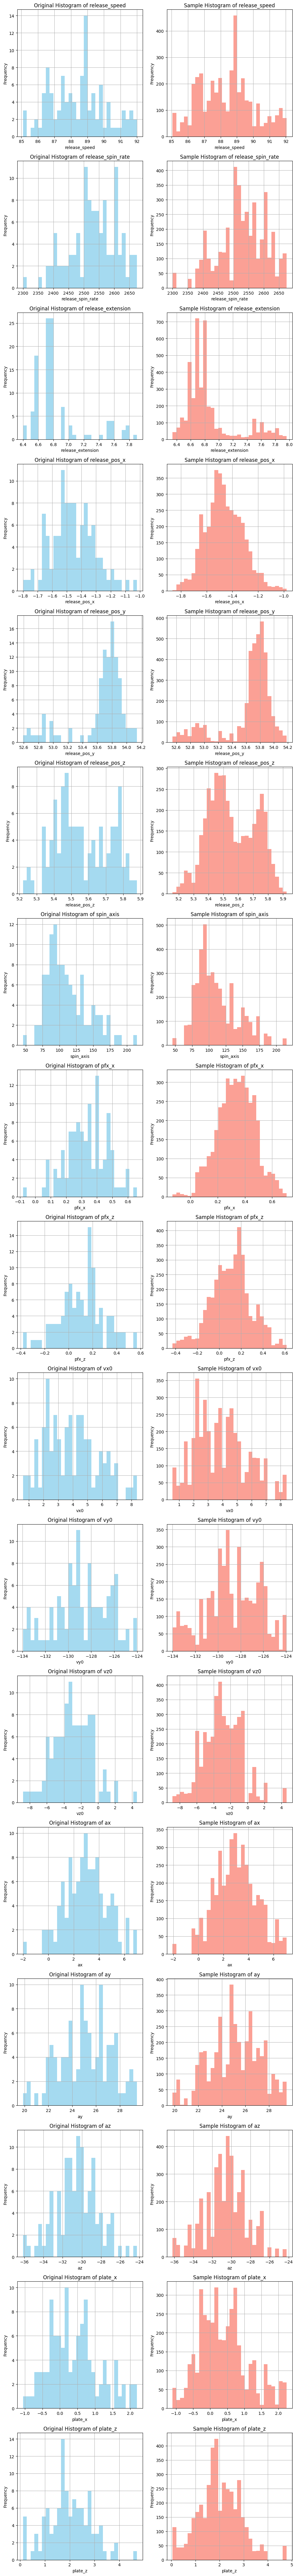